# Imports and setup

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
cd /content/drive/My Drive/Colab Notebooks/Blood_Cells/images

/content/drive/My Drive/Colab Notebooks/Blood_Cells/images


In [6]:
!ls

TEST  TEST_SIMPLE  TRAIN


In [0]:
# Unzipping is faster than to upload unzipped to drive
# from zipfile import ZipFile
# file_name = 'images.zip'

# with ZipFile(file_name, 'r') as zip:
#   zip.extractall()
#   print('Done')

In [8]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [9]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn as sns
# import keras

pd.set_option('display.max_columns', None, 'display.max_rows', 100)

In [0]:
# Imports for the Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16 as PretrainedModel, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from glob import glob

import sys, os

from tensorflow.keras.models import load_model

from sklearn.utils import shuffle

In [12]:
!ls TEST

EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [13]:
!ls TRAIN

EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [14]:
!ls TEST_SIMPLE  

EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [0]:
# Holding the paths:
train_path = 'TRAIN'
valid_path = 'TEST'
test_path = 'TEST_SIMPLE'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
test_images = glob(test_path + '/*/*.jp*g')

In [16]:
# useful for getting number of classes
folders = glob(train_path + '/*')
len(folders)

4

In [17]:
print('# Training Images {}'.format(len(image_files)))
print('# Validation Images {}'.format(len(valid_image_files)))
print('# Testing Images {}'.format(len(test_images)))

# Training Images 9957
# Validation Images 2487
# Testing Images 71


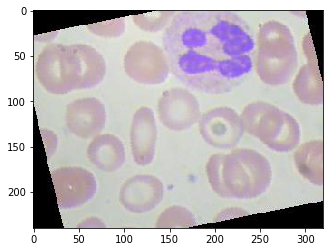

In [18]:
plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

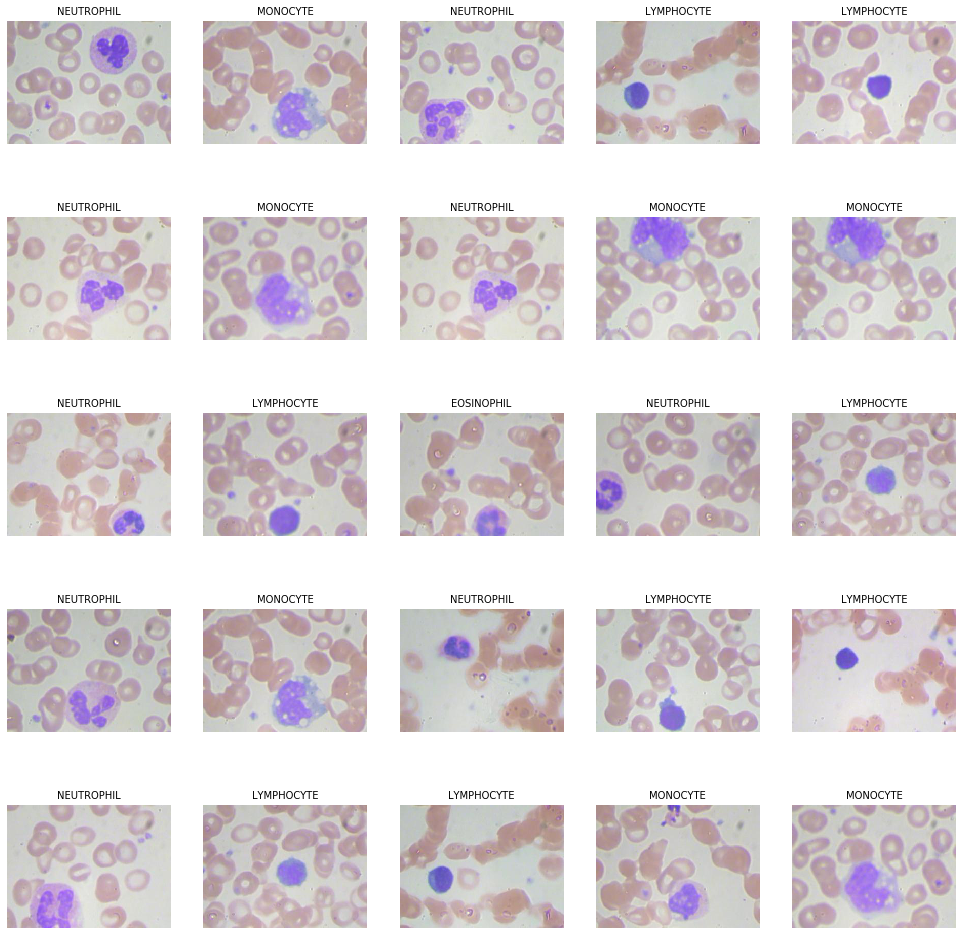

In [19]:
# Show some images from the training set
set_to_show = test_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)

for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*.jp*g'))
    axes[i].imshow(image.load_img(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

#Building the model

In [0]:
# Make all images one size
IMAGE_SIZE = [200, 200]

In [21]:
ptm = PretrainedModel(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

# freeze pretrained model weights
ptm.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [22]:
# map the data into feature vectors
# Keras image data generator returns classes one-hot encoded

K = len(folders)
x = Flatten()(ptm.output)
x = Dense(K, activation='softmax')(x)

model = Model(inputs = ptm.input, outputs=x)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
# Create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

In [24]:
batch_size = 128

# create generators
train_generator = gen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
)

valid_generator = gen.flow_from_directory(
    valid_path,
    target_size=IMAGE_SIZE,
    class_mode="categorical",
    batch_size=batch_size,
)

test_generator = gen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
)


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [25]:
# print(test_generator.class_indices)
labels = [None]*len(test_generator.class_indices)
for k, v in test_generator.class_indices.items():
  labels[v] = k
labels

['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

In [0]:
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [0]:
start_time = time.time()
r = model.fit_generator(
    train_generator,
    validation_data=valid_generator,
    epochs = 5,
    steps_per_epoch=int(np.ceil(len(image_files) / batch_size)),
    validation_steps=int(np.ceil(len(valid_image_files) / batch_size)),    
)
end_time = time.time()
# Save the model
model.save('Blood_v1.h5')

# Save the history
history = pd.DataFrame(r.history)
history.to_csv('history_Blood_v1.csv', index=False)

#print execution time
print('Starttime : {}'.format(start_time))
print('Endtime : {}'.format(end_time))

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 78 steps, validate for 20 steps
Epoch 1/5
19/78 [======>.......................] - ETA: 39:25 - loss: 9.7669 - accuracy: 0.3676 